# Image Captioning Neural Model (SC4001)

In [1]:
!pip install pillow opencv-python nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import os
from PIL import Image
import cv2
import random
from textwrap import wrap

import math

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /Users/chufeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"  # macbook uses metal performance shaders to GPU accelearation
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### 1.1 Retrieving the datasets

In [4]:
captions = pd.read_csv('./flickr30k_images/captions.csv', delimiter='|')
images = os.listdir('./flickr30k_images/flickr30k_images')

valid_imgExt = [".jpg", ".jpeg", ".png"]

image_size = [(64, 64), (128, 128), (224, 224), (256, 256), (29)]

# We will first use (224, 244) for the image sizes

def show_images(num, images):
    plt.figure(figsize=(25, 25))

    # Randomly select images
    r = random.randint(0, len(images)-num-1)

    for i, filename in enumerate(images[r:r+num]):
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join('./flickr30k_images/flickr30k_images', filename), 'rb') as img:
            img = Image.open(img).resize(image_size[3])
            plt.subplot(5, 5, i+1)
            plt.imshow(img)
            plt.title("\n".join(wrap(get_caption(filename, captions), 20)))
            plt.subplots_adjust(hspace=0.8)
            img.close()

    plt.show()

def get_caption(filename, captions):
    cap = captions[captions['image_name'] == filename][' comment'].values
    return cap[random.randint(0, len(cap)-1)]

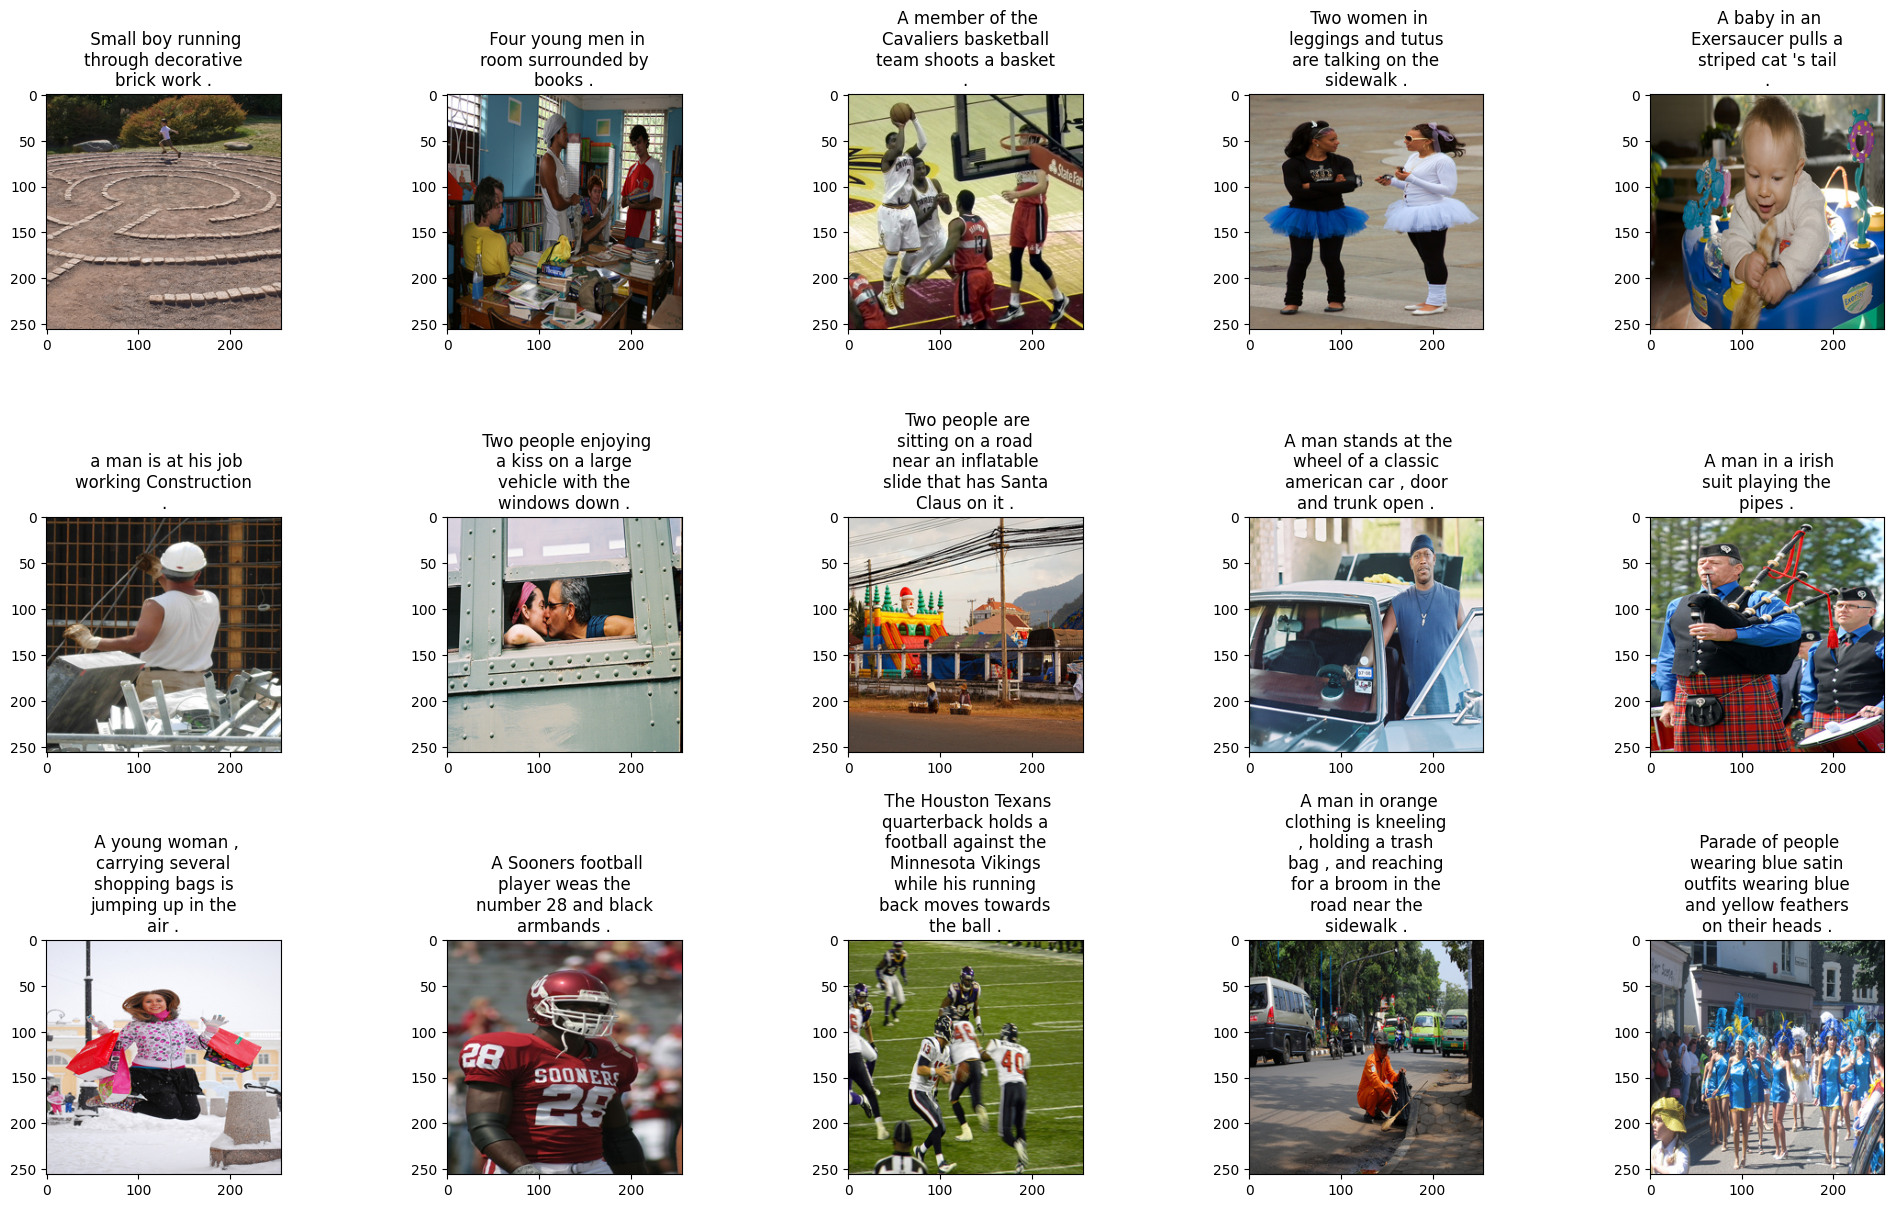

In [5]:
show_images(15, images)

### 1.2 Analysing datasets
- Images
- Captions

In [6]:
# images dataset
total_width = total_height = 0

for filename in images:
    try:
        if os.path.splitext(filename)[1].lower() not in valid_imgExt:
            continue
        with open(os.path.join('./flickr30k_images/flickr30k_images/', filename), 'rb') as file:
            img = Image.open(file)
            width, height = img.size

            total_width += width
            total_height += height
            img.close()
    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

average_width = total_width / len(images)
average_height = total_height / len(images)

print(f"Average Width: {average_width}")
print(f"Average Height: {average_height}")

Average Width: 459.578228724241
Average Height: 395.10662262073305


In [7]:
# captions dataset
display(captions.head(10))
print("We can observe that there are multiple captions for each image, denoted by \'comment_number\'.")

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


We can observe that there are multiple captions for each image, denoted by 'comment_number'.


### 2.1 Clean captions dataset

- Convert all char to lowercase
- Remove unncecessary white spaces
- Only allow valid char in the English language
- Remove special char eg. '&', '*', '(', ')', etc

In [8]:
def text_preprocessing(df):
    df[' comment'] = df[' comment'].str.lower()
    df[' comment'] = df[' comment'].str.replace("[^A-Za-z]", " ", regex=True)
    df[' comment'] = df[' comment'].str.replace("\s+", " ", regex=True)
    df[' comment'] = df[' comment'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    df[' comment'] = "Sseq " + df[' comment'] + " Eseq"
    return df

captions_clean = captions.copy()
captions_clean = text_preprocessing(captions_clean)
captions_clean.head(10)

,image_name,comment_number,comment
0,1000092795.jpg,0,Sseq two young guys with shaggy hair look at t...
1,1000092795.jpg,1,Sseq two young white males are outside near ma...
2,1000092795.jpg,2,Sseq two men in green shirts are standing in y...
3,1000092795.jpg,3,Sseq man in blue shirt standing in garden Eseq
4,1000092795.jpg,4,Sseq two friends enjoy time spent together Eseq
5,10002456.jpg,0,Sseq several men in hard hats are operating gi...
6,10002456.jpg,1,Sseq workers look down from up above on piece ...
7,10002456.jpg,2,Sseq two men working on machine wearing hard h...
8,10002456.jpg,3,Sseq four men on top of tall structure Eseq
9,10002456.jpg,4,Sseq three men on large rig Eseq


### 2.2 Tokenise captions dataset

In [29]:
tokenised_sentences = []

for sentence in captions[' comment']:
    tokenised_sentences.append(word_tokenize(sentence))

tokens = []
for sentence in tokenised_sentences:
    for token in sentence:
        tokens.append(token)

# Create vocabulary based on the tokens (words) in the caption dataset
vocabulary = []
token_counts = Counter(tokens)
for token, count in token_counts.most_common():
    vocabulary.append(token)


# display(token_counts)
# display(vocabulary)
print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 23436
